In [1]:
import theano.tensor as tt
import pysal as ps
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import numpy as np
import pandas as pd
import ops
import distributions as spdist
import scipy.sparse as spar
import scipy.sparse.linalg as spla
import pymc3 as mc
%matplotlib inline

This notebook compares timings for log determinants of the form:

$$ log(|A|) = log(|I - \rho W|) $$

where $W$ is a row-standardized spatial linkage matrix of dimension $N \times N$ and $I$ is an identity matrix. These kinds of determinants are common in spatial models, where they are required for the covariance of a multivariate normal distribution. 

For this example, I'll use the counties in Texas, Oklahoma, Arkansas, and Louisiana for an example. 

In [2]:
df = ps.pdio.read_files(ps.examples.get_path('south.shp'))
df = df.query('STATE_NAME in ("Texas", "Oklahoma", "Arkansas", "Louisiana")')

W = ps.weights.Queen.from_dataframe(df)

W.transform = 'r'
print('There are {} observations in the problem frame'.format(W.n))

There are 470 observations in the problem frame


One method, that implemented recently in PyMC3, uses singular value decomposition to compute the log determinant of positive semidefinite covariance matrices common in multivariate normal distributions. In general, since the covariance matrix is positive semidefinite, we know its determinant is positive. 

Since the product of singular values is equivalent to the magnitude of the determinant, the product of singular values for a positive semidefinite matrix is *exactly equal* to its determinant. Thus, with singular values $s_i$, 

$$ \Pi_s s_i = |I - \rho W| \rightarrow \sum_i log(s_i) = log(|I - \rho W|) $$

This is great, since this means we can use efficient SVD methods already implemented in theano for the log determinant computations which typically have $O(n^3)$ complexity for our log determinant in this case, since the SVD is applied to square matrices and SVD on an $m \times n$ matrix has complexity $O(min(n^2m, m^2n))$, depending on whether $m$ or $n$ is larger. 

While this is a good strategy, this results in the evaluation of an SVD of $A$ each time a determinant is required. In a Markov Chain Monte Carlo strategy, this means an SVD is required each iteration. Often, the number of iterations for an MCMC sampler exceeds the number of observations significantly.

Thus, what we're really looking for is fast determinants of a matrix with known *repeated* structure. If there were some way to pre-factor $A$ over a range of $\rho$, the cost of the matrix factorization would be amortized over $t$. One common approximation strategy is to do this prefactoring by evaluating $A$ at many $\rho$, and then storing the resulting log determinants and linearly-interpolating or inverse sampling between these values. 

Another prefactoring strategy uses the eigenvalues of $W$. This is due to a proof by spatial statistician Keith Ord in 1975, and lets us compute $|A|$ as a linear-time function of the eigenvalues of $W$ and $\rho$:

$$ log|A| = \sum_i^n log(1 - \rho * e_i)$$

Thus, if $e_i$ is available, then this is attainable.

Additionally, $A$ is a sparse matrix, since $W$ is very sparse. For example, for an adjacency matrix for counties in TX, LA, AR, and OK, just shy of 1% of entries in the matrix are nonzero:

In [12]:
W.nonzero / W.n**2

0.012331371661385242

Thus, a dedicated sparse matrix algorithm to compute the log determinant may provide speedups. Sparse matrix algorithms exploit the fact that so many elements of the matrix are zero and can often provide quantities of interest faster than a dense matrix algorithm. 

An easy sparse algorithm for this problem uses `scipy.sparse.linalg.splu`, the SuperLU-backed Sparse LU Decomposition. Using a similar logic to the SVD strategy, an LU decomposition of $A$ is constructed:

$$ LU = A$$

and the sum of the logged absolute value of the diagonals provides the log determinant. Since the SuperLU algorithm provides $L$ with all ones on the diagonal, the upper triangular matrix can be used alone for the log determinant. 
$$ log|A| = \sum_i^n(log(|U_{ii}|))$$

### Comparing the three methods

So, to compare speed, I'll look at the three methods on the very sparse but relatively small $470 \times 470$ matrix of counties in TX, OK, AR, and LA. 

In the image below, the weights matrix is shown. Entries that are non-zero are in black. So, the matrix is very sparse and diagonally-dominant. 

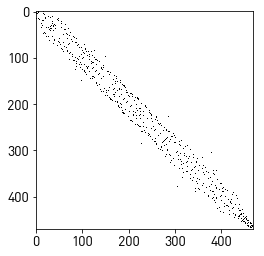

In [21]:
plt.imshow(W.sparse.toarray()>0, cmap='Greys')

Both the Ord and LU determinant `Op`s are specific to a given $W$, so they must be instantiated before running the comparison. For fairness, I'll measure the time it takes to instantiate either of them, and consider the number of evaluations of the log determinant that is necessary to justify the caching/precomputation. 

In what follows, I run 1000 iterations of the log determinant computation for random $\rho$ in $[-1,1)$, the range of stable spatial autoregressive coefficients that are commonly encountered in practice. `sparse` contains the sparse LU decomposition, `dense` contains the standard PyMC3 SVD strategy, and `evals` contains the Ord Eigenvalue approach. 

In [22]:
import time as t
sparse = []
dense = []
evals = []
Wd = W.sparse.toarray()
I = np.eye(W.n)

cache_time = t.time()
spld = ops.CachedLogDet(W)
cache_time = t.time() - cache_time

eval_time = t.time()
np.linalg.eigvals(Wd)
eval_time = t.time() - eval_time

for _ in range(1000):
    rho = np.random.random()*2-1 #rho uniform over [-1,1)
    etime = t.time()
    result = spld(rho).eval()
    etime = t.time() - etime
    sparse.append((rho, result, etime))
    A = I - rho * Wd
    etime = t.time()
    result = mc.math.logdet(A).eval()
    etime = t.time() - etime
    dense.append((rho, result, etime))
    etime = t.time()
    result = ordld(rho).eval()
    etime = t.time() - etime
    evals.append((rho, result, etime))

In [23]:
sparse = np.asarray(sparse)
dense = np.asarray(dense)
evals = np.asarray(evals)

First off, the log determinant recovered by all approaches is identical:

In [38]:
np.testing.assert_allclose(sparse[:,1], evals[:,1])
np.testing.assert_allclose(sparse[:,1], dense[:,1])

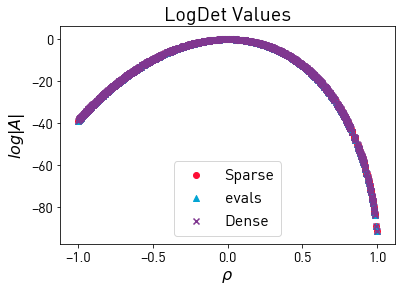

In [39]:
plt.scatter(sparse[:,0], sparse[:,1], label='Sparse', marker='o')
plt.scatter(evals[:,0], evals[:,1], label='evals', marker='^')
plt.scatter(dense[:,0], dense[:,1], marker='x', label='Dense')
plt.title('LogDet Values', fontsize=20)
plt.legend(fontsize=16, loc='lower center')
plt.xlabel(r'$\rho$', fontsize=16)
plt.ylabel(r'$log|A|$', fontsize=16)

Disregarding the precomputation time, the Eigenvalue method is the fastest both on average and in almost every pass. The sparse method takes over double the time that the eigenvalue method takes on average. And, the dense method takes over 10 times the time the sparse method requires, and nearly 30 times the average time for the eigenvalue method. 

In [45]:
evals[:,2].mean(), sparse[:,2].mean(), dense[:,2].mean()

(0.012054646730422974, 0.027914449214935303, 0.35224998950958253)

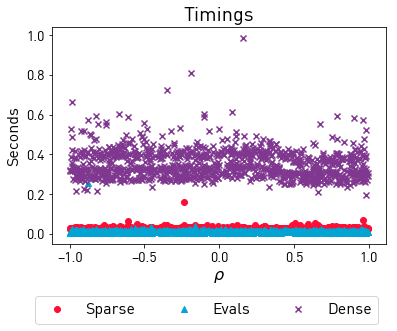

In [30]:
plt.scatter(sparse[:,0], sparse[:,2], label='Sparse', marker='o')
plt.scatter(evals[:,0], evals[:,2], label='Evals', marker='^')
plt.scatter(dense[:,0], dense[:,2], marker='x', label='Dense')
plt.title('Timings', fontsize=20)
plt.ylabel('Seconds', fontsize=16)
plt.xlabel(r'$\rho$', fontsize=16)
plt.legend(fontsize=16, ncol=3, bbox_to_anchor=(1.,-.2))

However, computing the eigenvalues takes a full two seconds of precomputation. So, for one-off log determinants, this method is exceedingly inefficient. However, after only seven evaluations of the log determinant, the precomputation method required by the eigenvalue strategy breaks even with the SVD time. 

In [67]:
np.mean([eval_time] + evals[:,2][:6].tolist()), dense[:,2].mean()

(0.30563088825770784, 0.35224998950958253)

However, it takes much longer to amorize the eigenvalue precomputation time compared to the sparse LU approach. The amortization curve for the sparse method is nearly flat, since the fraction of the total computation time consumed in precomputation is nearly zero. however, the amortization of the eigenvalue method is *very* steep, and becomes more efficient than the sparse evaluation method after around 125 evaluations of the log determinant.

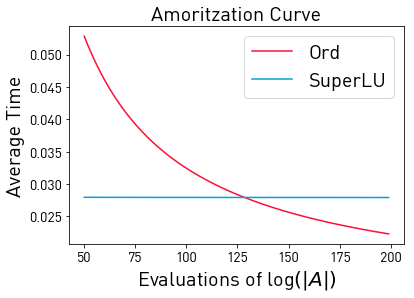

In [83]:
support = np.arange(50,200,1)
plt.plot(support, 
         [np.mean(eval_time/k + evals[:,2].mean()) for k in support], label='Ord')
plt.plot(support, 
         [np.mean(cache_time/k + sparse[:,2].mean()) for k in support], label='SuperLU')
plt.title('Amoritzation Curve', fontsize=20)
plt.ylabel('Average Time', fontsize=20)
plt.xlabel('Evaluations of log$(|A|)$', fontsize=20)
plt.legend(fontsize=20)

In general, it's difficult to characterize how this scales with respect to $N$, since the structure of the connectivity matrix for additional observations greatly affects the speed of the various approaches. However, it appears that, in general, for sparse $W$, the sparse LU or eigenvalue strategy are much more efficient for this specific problem. 